In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from model.gaussian_nb import GaussianNaiveBayes
from model.id3 import ID3
from model.knn import KNN
# from missingpy import MissForest

import warnings
warnings.filterwarnings("ignore")

In [2]:
basic_features_train = pd.read_csv('dataset/train/basic_features_train.csv')
content_features_train = pd.read_csv('dataset/train/content_features_train.csv')
additional_features_train = pd.read_csv('dataset/train/additional_features_train.csv')
labels_train = pd.read_csv('dataset/train/labels_train.csv')
time_features_train = pd.read_csv('dataset/train/time_features_train.csv')
flow_features_train = pd.read_csv('dataset/train/flow_features_train.csv')

basic_features_test = pd.read_csv('dataset/test/basic_features_test.csv')
content_features_test = pd.read_csv('dataset/test/content_features_test.csv')
additional_features_test = pd.read_csv('dataset/test/additional_features_test.csv')
time_features_test = pd.read_csv('dataset/test/time_features_test.csv')
flow_features_test = pd.read_csv('dataset/test/flow_features_test.csv')

metadata = pd.read_csv('dataset/train/UNSW-NB15_features-modified.csv')

In [3]:
df_train = pd.merge(basic_features_train, content_features_train, on='id')
df_train = pd.merge(df_train, additional_features_train, on='id')
df_train = pd.merge(df_train, labels_train, on='id')
df_train = pd.merge(df_train, time_features_train, on='id')
df_train = pd.merge(df_train, flow_features_train, on='id')

df_test = pd.merge(basic_features_test, content_features_test, on='id')
df_test = pd.merge(df_test, additional_features_test, on='id')
df_test = pd.merge(df_test, time_features_test, on='id')
df_test = pd.merge(df_test, flow_features_test, on='id')
df_train.drop('label',axis=1, inplace=True)

In [4]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 57.52 MB
Memory usage after optimization is: 31.44 MB
Decreased by 45.3%


In [6]:
## SPLIT TRAINING DATA INTO TRAINING AND VALIDATION SET

target_columns = ['attack_cat']
X_train = df_train.drop(target_columns, axis=1)
y_train = df_train[target_columns]
X_train.drop('id', axis=1, inplace=True)
cat_columns = metadata['Name'].loc[(metadata['Type '] == 'nominal') | (metadata['Type '] == 'binary') | (metadata['Type '] == 'Binary')].values
indices_to_remove = [i for i, val in enumerate(cat_columns) if val in target_columns or val == 'label']
cat_columns = np.delete(cat_columns, indices_to_remove)
num_columns = [x for x in X_train.columns if x not in cat_columns]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
## DATA CLEANING

### MISSING VALUES
len(X_train[X_train.isna().any(axis=1)]) * 100 /len(X_train)

for column in num_columns:
    missing_percentage = X_train[column].isna().sum() / len(X_train) * 100
    # print(f"Column {column} - {missing_percentage:.2f}% missing values")

for column in cat_columns:
    missing_percentage = X_train[column].isna().sum() / len(X_train) * 100
    # print(f"Column {column} - {missing_percentage:.2f}% missing values")

print("Skewness of each column:")
# for column in num_columns:
#     # print(column, ":", df_train[column].skew())

class CatMissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='most_frequent'):
        self.strategy = strategy
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        if self.strategy == 'most_frequent':
            imputer = SimpleImputer(strategy='most_frequent')
            return pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        elif self.strategy == 'missing_category':
            for col in X.columns:
                X[col] = X[col].fillna("Missing")
            return X
        
        return X

print("bebek")
    
class NumMissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='iterative'):
        self.strategy = strategy
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if self.strategy == 'iterative':
            # More advanced imputation
            imputer = IterativeImputer(
                max_iter=10, 
                random_state=42, 
                initial_strategy='median'
            )
            X_imputed = imputer.fit_transform(X)
            return pd.DataFrame(X_imputed, columns=X.columns)
        elif self.strategy == 'median':
            imputer = SimpleImputer(strategy='median')
            return pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        
        return X

print("ayam")

missingVal_pipeline = ColumnTransformer([
 ("num", NumMissingValueHandler(), num_columns),
 ("cat", CatMissingValueHandler(), cat_columns)
])

m_X_train = missingVal_pipeline.fit_transform(X_train)
m_X_train_df = pd.DataFrame(m_X_train, columns=list(num_columns) + list(cat_columns))
m_X_train_df

### OUTLIERS

class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method="winsorize"): 
        self.method = method
        return

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)

        for col in X_df.columns:
            if self.method == "winsorize":
                # Winsorization at 5th and 95th percentiles
                lower = np.percentile(X_df[col], 5)
                upper = np.percentile(X_df[col], 95)
                X_df[col] = np.clip(X_df[col], lower, upper)
            elif self.method == "iqr":
                Q1 = X_df[col].quantile(0.25)
                Q3 = X_df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                X_df[col] = X_df[col].clip(lower=lower_bound, upper=upper_bound)

        return X_df.values

print("bebek")

num_pipeline = Pipeline([
 ('imputer', NumMissingValueHandler()),
 ('outlier_handler', OutlierHandler()),
 ])

num_cat_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_columns),
 ("cat", CatMissingValueHandler(), cat_columns)
])

mo_X_train = num_cat_pipeline.fit_transform(X_train)
mo_X_train_df = pd.DataFrame(mo_X_train, columns=list(num_columns) + list(cat_columns))
mo_X_train_df

### REMOVE DUPLICATES

duplicate_rows_train = df_train[df_train.duplicated()]
duplicate_rows_test = df_test[df_test.duplicated()]
# print(duplicate_rows_train)
# print(duplicate_rows_test)

### FEATURE SCALING

#### Remove Useless Attribute

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        return X.drop('id', axis=1)
    

#### Remove Similar Attribute

constant_columns = mo_X_train_df[num_columns].loc[:, mo_X_train_df[num_columns].std() == 0]
# print("Constant columns:", constant_columns.columns.tolist())

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(mo_X_train_df[num_columns])
scaled_df = pd.DataFrame(scaled_data, columns=num_columns)

corr_df = scaled_df[num_columns].loc[:, mo_X_train_df[num_columns].std() != 0]
correlation_matrix = corr_df.corr()

high_corr = correlation_matrix.unstack() 
high_corr = high_corr[high_corr > 0.9]
high_corr = high_corr[high_corr < 1.0]
high_corr = high_corr.sort_values(ascending=False)

# Print the result
# print("High correlation pairs:")
# print(high_corr)

removed_attributes = set([x[0] for x in high_corr.index][0::2])
# print("Removed attribute: ", removed_attributes)
fmo_X_train_df = mo_X_train_df.drop(removed_attributes, axis=1)
fmo_X_train_df

num_columns = [x for x in num_columns if x not in removed_attributes]
cat_columns = [x for x in cat_columns if x not in removed_attributes]

print("sapi")

class SimiliarAttributeRemover(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)
        
        scaled_data = scaler.fit_transform(X_df)
        scaled_df = pd.DataFrame(scaled_data)

        # remove constant attribute
        corr_df = scaled_df.loc[:, scaled_df.std() != 0]
        correlation_matrix = corr_df.corr()

        high_corr = correlation_matrix.unstack() 
        high_corr = high_corr[high_corr > 0.9]
        high_corr = high_corr[high_corr < 1.0]
        high_corr = high_corr.sort_values(ascending=False)


        removed_attributes = [x[0] for x in high_corr.index][0::2]
        
        X_df.drop(removed_attributes, axis=1)

        return X_df.values

Skewness of each column:
bebek
ayam
bebek
sapi


kambing
Index(['dur', 'sbytes', 'dbytes', 'sttl', 'sloss', 'dloss', 'sload', 'dload',
       'spkts', 'dwin', 'stcpb', 'dtcpb', 'smean', 'dmean',
       'response_body_len', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd',
       'ct_srv_dst', 'ct_src_ltm', 'ct_dst_sport_ltm', 'sjit', 'djit',
       'sinpkt', 'dinpkt', 'proto', 'state', 'service', 'is_sm_ips_ports',
       'is_ftp_login'],
      dtype='object')
Variance from sklearn model:  [ 40.85  53.12  60.7   66.83  71.44  75.82  79.75  82.21  84.36  86.28
  88.13  89.49  90.73  91.83  92.83  93.74  94.6   95.4   96.15  96.78
  97.36  97.91  98.38  98.77  99.09  99.35  99.59  99.79  99.97 100.01]


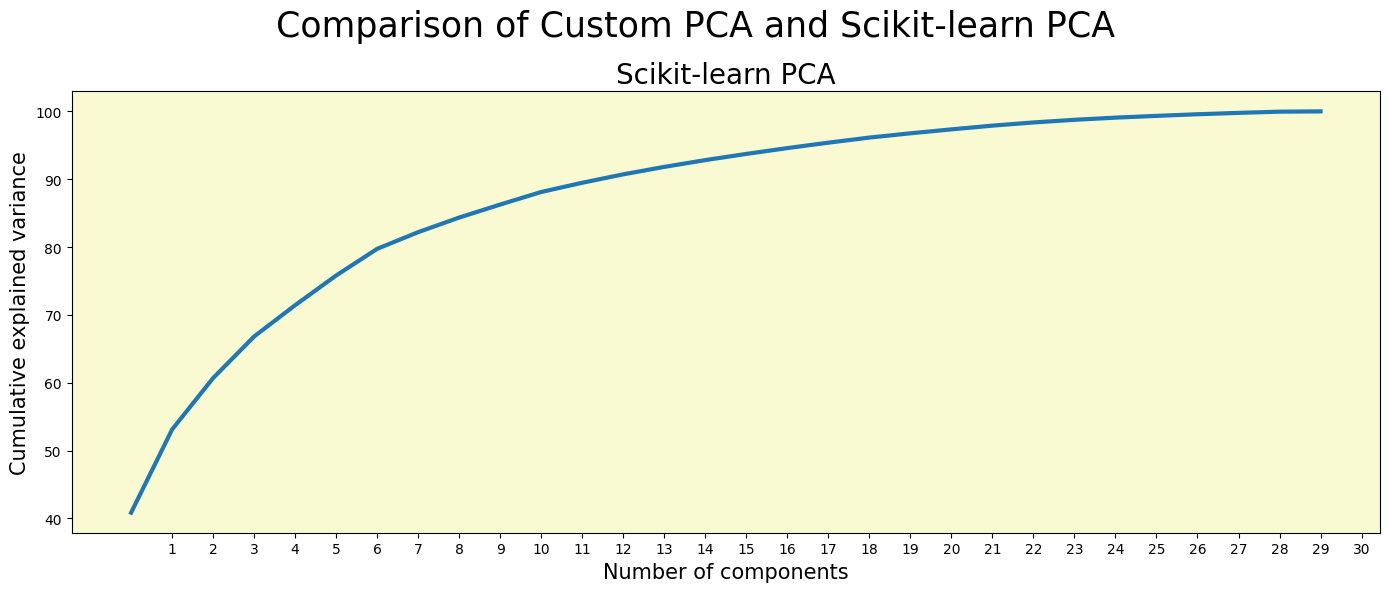

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.381967,0.590495,-0.069819,-0.064216,-0.298930,0.205427,-0.234693,-0.108585,-0.209750,0.053944,-0.376815,0.070910,0.034312,-0.195238,0.071013,-0.039864,-0.087474,0.102560
1,-0.740596,0.084834,-0.597543,-0.107565,0.068646,0.274530,0.040676,0.083157,-0.008610,-0.066564,-0.056345,-0.162224,-0.005851,-0.112014,-0.032579,0.071308,0.056353,0.004399
2,-1.187329,-0.166999,0.705582,0.103501,-0.062994,-0.163243,-0.047931,0.046352,-0.092122,-0.055738,-0.031339,-0.095183,0.007462,-0.077364,0.033566,-0.089026,0.072920,-0.052839
3,-0.881208,0.044305,-0.148067,0.060793,0.222008,-0.073791,-0.360594,0.524925,-0.051093,0.020278,0.035652,0.290522,0.183643,0.171983,0.349500,-0.045215,-0.252951,-0.232824
4,0.821752,0.301092,0.170807,0.689536,-0.001822,-0.235354,0.469514,0.300623,-0.012600,0.209416,-0.689713,0.119322,-0.261473,0.032800,-0.146274,-0.133110,0.017477,0.130544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140267,0.766507,0.973748,-0.023865,-0.642465,-0.022045,-0.258618,0.041918,-0.269573,-0.286339,0.081076,0.182417,0.273773,0.065632,-0.294257,-0.033221,0.079797,0.315653,-0.291425
140268,0.637794,0.984678,0.282845,-0.058975,-0.483095,0.250664,-0.262153,0.080104,0.009990,0.203244,0.137203,-0.082675,0.075399,0.016636,-0.124685,-0.189249,0.169360,0.082584
140269,-1.217822,-0.114813,0.424048,-0.065784,0.074485,0.005198,0.211191,-0.116491,0.109095,0.206967,0.106570,0.103244,-0.180803,0.052018,-0.029558,-0.011360,-0.162025,-0.129419
140270,-0.997803,-0.108530,0.097805,0.023825,0.043808,0.041167,0.102683,-0.050370,0.059223,0.064568,0.015688,-0.067311,-0.149828,0.030314,-0.010621,-0.043552,-0.143308,-0.115515


In [13]:
## DATA PREPROCESSING

### FEATURE ENCODING

class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.target_means_ = {}
        self.global_mean_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if y is None:
            raise ValueError("Target variable y must not be None.")

        label_encoder_ = LabelEncoder()
        y_encoded = pd.Series(label_encoder_.fit_transform(y.values.ravel()))

        self.global_mean_ = y_encoded.mean()
        for col in X.columns:
            # Smoothed target encoding
            grouped_means = y_encoded.groupby(X[col]).mean()
            counts = X[col].value_counts()
            smoothed_means = (grouped_means * counts + self.global_mean_ * 1) / (counts + 1)
            self.target_means_[col] = smoothed_means.to_dict()
        
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X_encoded = X.copy()
        for col, mapping in self.target_means_.items():
            if col in X_encoded.columns:
                # Map the encoded values, fill NaNs with the global mean
                X_encoded[col] = X_encoded[col].map(mapping).fillna(self.global_mean_)

        return X_encoded
    
print("kambing")

### DIMENSIONALITY REDUCTION

### Label encoding ###
LABELS = fmo_X_train_df.columns
print(LABELS)

encoder = LabelEncoder()

for col in cat_columns:
    # Check if object
    fmo_X_train_df[col] = encoder.fit_transform(fmo_X_train_df[col]) 

from sklearn.preprocessing import MinMaxScaler

### Scaling ###
mm_scaler = MinMaxScaler() 

# Apply Min-Max Scaling
fmo_X_train_df[LABELS] = mm_scaler.fit_transform(fmo_X_train_df[LABELS])

from sklearn.decomposition import PCA

# Fit sklearn PCA
pca = PCA(n_components=30)
pca.fit(fmo_X_train_df)

# The amount of variance that each PC explains
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)
print("Variance from sklearn model: ", var)

# Plotting
fig, ax= plt.subplots(figsize=(14, 6))

# Plot for scikit-learn PCA
ax.plot(var, linewidth=3)
ax.set_xlabel('Number of components', fontsize=15)
ax.set_ylabel('Cumulative explained variance', fontsize=15)
ax.set_title('Scikit-learn PCA', fontsize=20)
ax.set_xticks(np.arange(1, len(var) + 1, step=1))
ax.set_facecolor('lightgoldenrodyellow')

# Overall figure settings
fig.suptitle('Comparison of Custom PCA and Scikit-learn PCA', fontsize=25)
plt.tight_layout()
plt.show()

pca = PCA(n_components=18)
rfmo_X_train_df = pd.DataFrame(pca.fit_transform(fmo_X_train_df), columns=[x for x in range(1, 19)])
rfmo_X_train_df


In [14]:
## COMPILE PREPROCESSING PIPELINE

class CatMissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='most_frequent'):
        self.strategy = strategy
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        if self.strategy == 'most_frequent':
            imputer = SimpleImputer(strategy='most_frequent')
            return pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        elif self.strategy == 'missing_category':
            for col in X.columns:
                X[col] = X[col].fillna("Missing")
            return X
        
        return X
    
class NumMissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='iterative'):
        self.strategy = strategy
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if self.strategy == 'iterative':
            # More advanced imputation
            imputer = IterativeImputer(
                max_iter=10, 
                random_state=42, 
                initial_strategy='median'
            )
            X_imputed = imputer.fit_transform(X)
            return pd.DataFrame(X_imputed, columns=X.columns)
        elif self.strategy == 'median':
            imputer = SimpleImputer(strategy='median')
            return pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        
        return X

class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method="winsorize"): 
        self.method = method
        return

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)

        for col in X_df.columns:
            if self.method == "winsorize":
                # Winsorization at 5th and 95th percentiles
                lower = np.percentile(X_df[col], 5)
                upper = np.percentile(X_df[col], 95)
                X_df[col] = np.clip(X_df[col], lower, upper)
            elif self.method == "iqr":
                Q1 = X_df[col].quantile(0.25)
                Q3 = X_df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                X_df[col] = X_df[col].clip(lower=lower_bound, upper=upper_bound)

        return X_df.values

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        return X.drop('id', axis=1)

class SimiliarAttributeRemover(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)
        
        scaled_data = scaler.fit_transform(X_df)
        scaled_df = pd.DataFrame(scaled_data, columns=X_df.columns)

        # remove constant attribute
        corr_df = scaled_df.loc[:, scaled_df.std() != 0]
        correlation_matrix = corr_df.corr()

        high_corr = correlation_matrix.unstack() 
        high_corr = high_corr[high_corr > 0.9]
        high_corr = high_corr[high_corr < 1.0]
        high_corr = high_corr.sort_values(ascending=False)


        removed_attributes = [x[0] for x in high_corr.index][0::2]
        
        X_df.drop(removed_attributes, axis=1)

        return X_df.values

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
import pandas as pd

class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.target_means_ = {}
        self.global_mean_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if y is None:
            raise ValueError("Target variable y must not be None.")

        label_encoder_ = LabelEncoder()
        y_encoded = pd.Series(label_encoder_.fit_transform(y.values.ravel()))

        self.global_mean_ = y_encoded.mean()
        for col in X.columns:
            # Smoothed target encoding
            grouped_means = y_encoded.groupby(X[col]).mean()
            counts = X[col].value_counts()
            smoothed_means = (grouped_means * counts + self.global_mean_ * 1) / (counts + 1)
            self.target_means_[col] = smoothed_means.to_dict()
        
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X_encoded = X.copy()
        for col, mapping in self.target_means_.items():
            if col in X_encoded.columns:
                # Map the encoded values, fill NaNs with the global mean
                X_encoded[col] = X_encoded[col].map(mapping).fillna(self.global_mean_)

        return X_encoded
    
print("ayam")

from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler

feature_selector = SelectKBest(score_func=mutual_info_classif, k=25)

cat_pipeline = Pipeline([
    ('imputer', CatMissingValueHandler(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

num_pipeline = Pipeline([
    ('imputer', NumMissingValueHandler(strategy='iterative')),
    ('outlier_handler', OutlierHandler(method='winsorize')),
    ('scaler', RobustScaler()),
    ('power_transform', PowerTransformer(method='yeo-johnson'))
])

num_cat_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns)
])

final_pipeline = Pipeline([
    ('num_cat', num_cat_pipeline),
    ('feature_selector', SelectKBest(score_func=mutual_info_classif, k=25)),
    ('d_reduction', PCA(n_components=18))
])

ayam


In [15]:
X_train_prepared = final_pipeline.fit_transform(X_train, y_train)
X_test_prepared = final_pipeline.fit_transform(X_val, y_val)

In [16]:
## MODELIING AND VALIDATION

In [42]:
import sys
import importlib

# Remove cached module
if "model.id3" in sys.modules:
    del sys.modules["model.id3"]

# Reload the module
import model.id3
importlib.reload(model.id3)

<module 'model.id3' from '/Users/denisefeliciatiowanni/Desktop/uni/S03E01/IF3170 AI/Tubes2-AI/model/id3.py'>

In [43]:
print("X_train_prepared shape:", X_train_prepared.shape)
print("X_test_prepared shape:", X_test_prepared.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("Unique labels in y_train:", np.unique(y_train))

X_train_prepared shape: (140272, 18)
X_test_prepared shape: (35069, 18)
y_train shape: (140272, 1)
y_val shape: (35069, 1)
Unique labels in y_train: ['Analysis' 'Backdoor' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']


In [44]:
# from model.id3x import ID3
# from sklearn.metrics import f1_score, classification_report
# import time

# # Start timer
# start_time = time.time()

# # Initialize ImprovedID3 with hyperparameters
# max_depth = 20
# id3_model = ID3(
#     max_depth=max_depth,
#     min_samples_split=20,
#     min_impurity_decrease=0.0001
# )

# # Fit the model
# print("Training the Improved ID3 model...")
# X_train_feature_names = [f'feature_{i}' for i in range(X_train_prepared.shape[1])]
# print(X_train_feature_names)
# id3_model.fit(X_train_prepared, y_train, feature_names=X_train_feature_names)

# # Predict on the test data
# print("Making predictions...")
# y_pred = id3_model.predict(np.array(X_test_prepared))

# print(y_pred)

# # Calculate F1 macro score
# f1_macro = f1_score(y_val, y_pred, average='macro')

# # Print the F1 score and classification report
# print(f"F1 Macro Score (max_depth={max_depth}): {f1_macro}")
# print("\nClassification Report:")
# print(classification_report(y_val, y_pred))

# # End timer
# end_time = time.time()
# print(f"\nTotal Time Taken: {end_time - start_time:.2f} seconds")

In [45]:
# from model.id3x import ID3
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import f1_score, classification_report
# import numpy as np
# import time

# # Convert y_train to numpy array if it's not already
# y_train = np.array(y_train)

# # Start overall timer
# total_start_time = time.time()

# # K-Fold Cross-Validation Parameters
# n_splits = 5  # Number of folds
# max_depth = 20
# min_samples_split = 20
# min_impurity_decrease = 0.0001

# # Prepare storage for cross-validation results
# cv_f1_scores = []
# cv_classification_reports = []

# # Create Stratified K-Fold
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Feature names preparation
# X_train_feature_names = [f'feature_{i}' for i in range(X_train_prepared.shape[1])]

# # Perform K-Fold Cross-Validation
# print(f"Performing {n_splits}-Fold Cross-Validation...")
# fold_start_time = time.time()

# for fold, (train_index, val_index) in enumerate(skf.split(X_train_prepared, y_train), 1):
#     print(f"\n--- Fold {fold} ---")
    
#     # Split data for this fold using numpy indexing
#     X_train_fold = X_train_prepared[train_index]
#     y_train_fold = y_train[train_index]
#     X_val_fold = X_train_prepared[val_index]
#     y_val_fold = y_train[val_index]
    
#     # Initialize ID3 model for this fold
#     id3_model = ID3(
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_impurity_decrease=min_impurity_decrease
#     )
    
#     # Train the model
#     print("Training the ID3 model...")
#     id3_model.fit(X_train_fold, y_train_fold, feature_names=X_train_feature_names)
    
#     # Predict on validation data
#     print("Making predictions...")
#     y_pred_fold = id3_model.predict(X_val_fold)
    
#     # Calculate F1 macro score for this fold
#     f1_macro_fold = f1_score(y_val_fold, y_pred_fold, average='macro')
#     cv_f1_scores.append(f1_macro_fold)
    
#     # Generate and store classification report for this fold
#     fold_classification_report = classification_report(y_val_fold, y_pred_fold)
#     cv_classification_reports.append(fold_classification_report)
    
#     # Print fold-specific results
#     print(f"Fold {fold} - F1 Macro Score: {f1_macro_fold}")
#     # print("\nClassification Report:")
#     # print(fold_classification_report)

# # Calculate and print overall cross-validation results
# print("\n--- Cross-Validation Summary ---")
# print(f"Average F1 Macro Score: {np.mean(cv_f1_scores):.4f} ± {np.std(cv_f1_scores):.4f}")
# print("\nDetailed Fold F1 Scores:")
# for fold, score in enumerate(cv_f1_scores, 1):
#     print(f"Fold {fold}: {score:.4f}")

# # Final test set evaluation (optional)
# print("\n--- Final Test Set Evaluation ---")
# # Initialize final model with best hyperparameters
# final_model = ID3(
#     max_depth=max_depth,
#     min_samples_split=min_samples_split,
#     min_impurity_decrease=min_impurity_decrease
# )

# # Train on full training data
# final_model.fit(X_train_prepared, y_train, feature_names=X_train_feature_names)

# # Predict on test set
# y_pred_test = final_model.predict(X_test_prepared)

# # Calculate final test set metrics
# final_f1_macro = f1_score(y_val, y_pred_test, average='macro')
# final_classification_report = classification_report(y_val, y_pred_test)

# print(f"Test Set F1 Macro Score: {final_f1_macro}")
# # print("\nTest Set Classification Report:")
# # print(final_classification_report)

# # End timer
# total_end_time = time.time()
# print(f"\nTotal Time Taken: {total_end_time - total_start_time:.2f} seconds")

In [46]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import f1_score, classification_report
# import numpy as np
# import time

# # Convert y_train to numpy array if it's not already
# y_train = np.array(y_train)

# # Start overall timer
# total_start_time = time.time()

# # K-Fold Cross-Validation Parameters
# n_splits = 5  # Number of folds

# # Hyperparameters for Decision Tree (comparable to previous ID3 implementation)
# max_depth = 20
# min_samples_split = 20

# # Prepare storage for cross-validation results
# cv_f1_scores = []
# cv_classification_reports = []

# # Create Stratified K-Fold
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Feature names preparation (optional, but kept for consistency)
# X_train_feature_names = [f'feature_{i}' for i in range(X_train_prepared.shape[1])]

# # Perform K-Fold Cross-Validation
# print(f"Performing {n_splits}-Fold Cross-Validation with Scikit-learn Decision Tree...")
# fold_start_time = time.time()

# for fold, (train_index, val_index) in enumerate(skf.split(X_train_prepared, y_train), 1):
#     print(f"\n--- Fold {fold} ---")
    
#     # Split data for this fold using numpy indexing
#     X_train_fold = X_train_prepared[train_index]
#     y_train_fold = y_train[train_index]
#     X_val_fold = X_train_prepared[val_index]
#     y_val_fold = y_train[val_index]
    
#     # Initialize Decision Tree model for this fold
#     # Using entropy criterion to mimic ID3 algorithm
#     sklearn_dt_model = DecisionTreeClassifier(
#         criterion='entropy',  # Same as ID3's information gain
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         random_state=42  # For reproducibility
#     )
    
#     # Train the model
#     print("Training the Scikit-learn Decision Tree model...")
#     sklearn_dt_model.fit(X_train_fold, y_train_fold)
    
#     # Predict on validation data
#     print("Making predictions...")
#     y_pred_fold = sklearn_dt_model.predict(X_val_fold)
    
#     # Calculate F1 macro score for this fold
#     f1_macro_fold = f1_score(y_val_fold, y_pred_fold, average='macro')
#     cv_f1_scores.append(f1_macro_fold)
    
#     # Generate and store classification report for this fold
#     fold_classification_report = classification_report(y_val_fold, y_pred_fold)
#     cv_classification_reports.append(fold_classification_report)
    
#     # Print fold-specific results
#     print(f"Fold {fold} - F1 Macro Score: {f1_macro_fold}")
#     # print("\nClassification Report:")
#     # print(fold_classification_report)

# # Calculate and print overall cross-validation results
# print("\n--- Cross-Validation Summary ---")
# print(f"Average F1 Macro Score: {np.mean(cv_f1_scores):.4f} ± {np.std(cv_f1_scores):.4f}")
# print("\nDetailed Fold F1 Scores:")
# for fold, score in enumerate(cv_f1_scores, 1):
#     print(f"Fold {fold}: {score:.4f}")

# # Final test set evaluation (optional)
# print("\n--- Final Test Set Evaluation ---")
# # Initialize final model with best hyperparameters
# final_model = DecisionTreeClassifier(
#     criterion='entropy',
#     max_depth=max_depth,
#     min_samples_split=min_samples_split,
#     random_state=42
# )

# # Train on full training data
# final_model.fit(X_train_prepared, y_train)

# # Predict on test set
# y_pred_test = final_model.predict(X_test_prepared)

# # Calculate final test set metrics
# final_f1_macro = f1_score(y_val, y_pred_test, average='macro')
# final_classification_report = classification_report(y_val, y_pred_test)

# print(f"Test Set F1 Macro Score: {final_f1_macro}")
# # print("\nTest Set Classification Report:")
# # print(final_classification_report)

# # End timer
# total_end_time = time.time()
# print(f"\nTotal Time Taken: {total_end_time - total_start_time:.2f} seconds")

In [48]:
from model.id3 import ID3
import pandas as pd
from sklearn.metrics import f1_score

max_depth = 20
min_samples_split = 20
min_impurity_decrease = 0.0001

# Train the final ID3 model
final_model = ID3(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_impurity_decrease=min_impurity_decrease
)

# Prepare feature names
X_train_feature_names = [f'feature_{i}' for i in range(X_train_prepared.shape[1])]

# Fit the model on entire training data
final_model.fit(X_train_prepared, y_train, feature_names=X_train_feature_names)


X_test_set_prepared = final_pipeline.transform(df_test.drop(columns=['id']))

# Make predictions on test set
predictions = final_model.predict(X_test_set_prepared)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': df_test['id'].values,
    'attack_cat': predictions
})

# Save to CSV
submission.to_csv('id3_submission2.csv', index=False)
print("ID3 Submission CSV saved successfully!")

ID3 Submission CSV saved successfully!


In [2]:
import sys
import importlib

# Remove cached module
if "model.knn_tes" in sys.modules:
    del sys.modules["model.knn_tes"]

# Reload the module
import model.knn_tes
importlib.reload(model.knn_tes)

<module 'model.knn_tes' from '/Users/denisefeliciatiowanni/Desktop/uni/S03E01/IF3170 AI/Tubes2-AI/src/model/knn_tes.py'>

In [ ]:
# WORK
from model.knn_tes import KNN

knn_model = KNN(distance='euclidean', n_neighbors=5, batch_size=250, verbose=True)

knn_model.fit(X_train_prepared, y_train)

X_test_set_prepared = final_pipeline.transform(df_test.drop(columns=['id']))

predictions = knn_model.predict(X_test_set_prepared)

submission = pd.DataFrame({
    'id': df_test['id'].values,
    'attack_cat': predictions
})

# Save to CSV
submission.to_csv('knn_submission1.csv', index=False)
print("ID3 Submission CSV saved successfully!")

# y_pred = knn_model.predict(X_test_prepared)

# # Evaluate:
# from sklearn.metrics import accuracy_score, f1_score, classification_report

# accuracy = accuracy_score(y_val, y_pred)
# f1 = f1_score(y_val, y_pred, average='macro')

# print(f"Accuracy: {accuracy}")
# print(f"F1 Score: {f1}")
# # print("Classification Report:\n", classification_report(y_val, y_pred))

Model fitted with 140272 training samples.
Processing batch 1/83...
Batch 1 processed in 109.45 seconds.
Processing batch 2/83...
Batch 2 processed in 122.61 seconds.
Processing batch 3/83...
Batch 3 processed in 125.20 seconds.
Processing batch 4/83...
Batch 4 processed in 125.11 seconds.
Processing batch 5/83...
Batch 5 processed in 116.96 seconds.
Processing batch 6/83...
Batch 6 processed in 121.74 seconds.
Processing batch 7/83...
Batch 7 processed in 102.25 seconds.
Processing batch 8/83...
Batch 8 processed in 115.56 seconds.
Processing batch 9/83...
Batch 9 processed in 122.37 seconds.
Processing batch 10/83...
Batch 10 processed in 87.22 seconds.
Processing batch 11/83...
Batch 11 processed in 87.77 seconds.
Processing batch 12/83...
Batch 12 processed in 90.90 seconds.
Processing batch 13/83...
Batch 13 processed in 88.51 seconds.
Processing batch 14/83...
Batch 14 processed in 105.27 seconds.
Processing batch 15/83...
Batch 15 processed in 110.20 seconds.
Processing batch 16